# Create nnUNet data and dataset json
---


In [9]:
from savenifti import convert_2d_image_to_nifti
from polygon import convert_polygons_to_annotations, get_tissue_union_from_mask
from filepath import convert_path, GenerateJson

# Libraries

In [10]:
import os
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.image.wholeslideimage import WholeSlideImage
#from wholeslidedata.accessories.asap.parser import AsapAnnotationParser
from matplotlib import pyplot as plt
from wholeslidedata.samplers.patchlabelsampler import SegmentationPatchLabelSampler
from shapely.geometry import Point
import numpy as np
import pandas as pd
import SimpleITK as sitk
from wholeslidedata.annotation.utils import cv2_polygonize
from shapely import geometry
from wholeslidedata.labels import Label
from wholeslidedata.annotation.structures import Annotation


In [11]:
# !pip3 install git+https://github.com/DIAGNijmegen/pathology-whole-slide-data@main
# !pip3 install --upgrade opencv-python-headless
# # # sudo apt update && sudo apt -y upgrade && sudo apt-get install -y openslide-tools
# restart kernel


# Data import

In [12]:
import yaml
import random
import os
current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"
camelyon_path = convert_path('/data/pathology/projects/pathology-mrifuse/yaml/data_camelyon16.yaml', current_os)
with open(camelyon_path, 'r') as f:
    yaml = yaml.safe_load(f)
root = yaml['path']['root']
camelyon = yaml['path']['camelyon16']     
train_data = yaml['data']['training']
random.seed(10)


### Colormap ASAP and labels

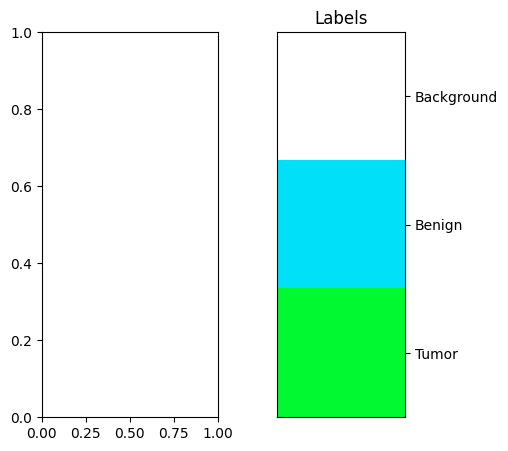

In [12]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
# import pylab as plt

colormap = [ [ 0, 0, 0, 0 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 0, 249, 50, 255 ] ]
colormap = np.array(colormap)/255.
cmap = LinearSegmentedColormap.from_list('my_cmap', colors=colormap)

label_names = ['Background','Benign','Tumor']
label_index = list(range(len(label_names)))
n_labels = len(label_names)
label_plot_args = {"cmap":cmap, "vmin":0, "vmax":255, "interpolation":"none"}


# Check images and annotations, gather pixel label distribution data for generating splits

In [13]:
labels={'Background':0,
        'Benign': 1, 
        'Tumor': 2}

In [14]:
import os
current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"
nnUNet_base = r"B:\projects\pathology-mrifuse"
nnUNet_data_root = convert_path(os.path.join(nnUNet_base, "nnUNet_raw_data"), current_os)
sorted(os.listdir(nnUNet_data_root))
task_name = 'Task029_camelyon_uncertainty_10'
task_root = os.path.join(nnUNet_data_root, task_name)
task_root = convert_path(task_root, current_os)
print("TASK:\t\t", task_name)
nnUNet_base_linux = convert_path(nnUNet_base, to=current_os)
print("nnUNet ROOT:\t", nnUNet_base_linux)
image_folder = os.path.join(task_root, "imagesTr")
image_folder = convert_path(image_folder, current_os)
label_folder = os.path.join(task_root, "labelsTr")
label_folder = convert_path(label_folder, current_os)
if not(os.path.isdir(image_folder)):
    os.makedirs(image_folder)
if not(os.path.isdir(label_folder)):
    os.makedirs(label_folder)

TASK:		 Task029_camelyon_uncertainty_10
nnUNet ROOT:	 B:\projects\pathology-mrifuse


In [2]:
from shapely.geometry import Point, Polygon
patch_size = (1024,1024)
patch_size = (1024,1024)
#sample every 100 pixel
sample_rate = patch_size[0]*patch_size[1]
plot = False
contrast_value = 20000 #remove white patch--- masks are bad quality
save = True
spacing = 1
# 'rst', 'umcu','rumc', 'lpon','cwz'
center_list = ['rumc', 'c']
cancer_list = [ 'macro']
# counts_wsi = np.zeros(n_labels)
for center in center_list:
    total_sample = 0
    for cancer in cancer_list:
        path = train_data['{}/breast/{}'.format(cancer, center)]
        for i in path:
            image = convert_path(i['image'].format(root='/data/pathology',camelyon16=camelyon), to = current_os)  
            mask = convert_path(i['mask'].format(root='/data/pathology',camelyon16=camelyon), to = current_os)
            filename = os.path.basename(image)[:-4]
            s = os.path.split(image)[-1].split(".")[-2]

            wsi = WholeSlideImage(image, backend="asap")
            wsi_mask = WholeSlideImage(mask, backend="asap")
            tissues = get_tissue_union_from_mask(wsi_mask, wsi,spacing,value = 1)
            
            for i, tissue in enumerate(tissues):
                if tissue.area<10*sample_rate:
                    continue               
                negative_sample_size = tissue.area/sample_rate
                # Define a polygon
                polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])

                # Define a point
                if negative_sample_size>10:
                    negative_sample_size = 10
                total_sample =total_sample + negative_sample_size
                for sample in range(int(negative_sample_size)):
                    point = Point(0, 0)

                    while not(tissue.contains(point)):
                        random_center_x = random.randint(int(np.min(tissue.coordinates[:,0])),int(np.max(tissue.coordinates[:,0])))
                        random_center_y = random.randint(int(np.min(tissue.coordinates[:,1])),int(np.max(tissue.coordinates[:,1])))
                        point = Point(random_center_x, random_center_y)

                    image_patch = wsi.get_patch(random_center_x,random_center_y, patch_size[0], patch_size[1], spacing)
                    mask_patch = wsi_mask.get_patch(random_center_x,random_center_y, patch_size[0], patch_size[1], spacing)
                    output_filename = filename+ '_{}'.format(i)+'_{}_1'.format(sample)
                    vals = image_patch.flatten
                    # calculate histogram
                    counts, bins = np.histogram(image_patch, range(255))
                    contrast = np.sum(counts)
                    if contrast<contrast_value:
                        continue
                    if save:
                        convert_2d_image_to_nifti(image_patch, os.path.join(image_folder, output_filename))
                        convert_2d_image_to_nifti(mask_patch, os.path.join(label_folder, output_filename), is_seg=True)   
                    if plot:
                        ratio = [14, 2]
                        fig, axs = plt.subplots(1,4,figsize=(15,4),gridspec_kw={'width_ratios': [ratio[0], ratio[0], ratio[0], ratio[-1]]})
                        fig.suptitle(s+"_ROI"+str(sample), fontsize=15)

                        # ROI
                        axs[0].imshow(image_patch, **label_plot_args)
                        axs[0].axis('off')
                        axs[0].set_title("ROI")

                        # Ground truth tissue
                        axs[1].imshow(mask_patch) 
                        axs[1].axis('off')
                        axs[1].set_title("Ground truth tissue")

                        # Overlay
                        axs[2].imshow(image_patch)
                        axs[2].imshow(mask_patch, alpha=0.5, **label_plot_args) 
                        axs[2].axis('off')
                        axs[2].set_title("Overlay")

                        # Labels                
                        axs[3].imshow([[i] for i in list(range(len(label_index)))], **label_plot_args)
                        axs[3].set_yticks(label_index) #, rotation=0, ha="right", rotation_mode="anchor")
                        axs[3].set_yticklabels(label_names)
                        axs[3].yaxis.tick_right()
                        axs[3].get_xaxis().set_visible(False)
                        axs[3].set_title("Labels")

                        plt.tight_layout()
                        plt.show()
                        


NameError: name 'train_data' is not defined

In [3]:
import math
sample_rate = patch_size[0]*patch_size[1]
spacing = 1
contrast_value = 20000 #remove white patch--- masks are bad quality
plot = False
# 'rst', 'umcu',,'rumc', 'lpon'
center_list = ['rst', 'umcu',,'rumc', 'lpon']
cancer_type = ['macro', 'micro', 'itc' ]
save = True
# counts_wsi = np.zeros(n_labels)
for center in center_list:
    dic_sample = {}
    for cancer in cancer_type:
        path = train_data['{}/breast/{}'.format(cancer, center)]
        for i in path[-15:]:
            image = i['image'].format(root='/data/pathology',camelyon16=camelyon)  
            mask = i['mask'].format(root='/data/pathology',camelyon16=camelyon) 
            annotation_path = '/data/pathology/archives/breast/camelyon/CAMELYON16/annotations/{}'
            filename = os.path.basename(image)[:-4]
            a = annotation_path.format(filename+'.xml')
            s = os.path.split(a)[-1].split(".")[-2]
            wsi = WholeSlideImage(image, backend="asap")
            wsi_mask = WholeSlideImage(mask, backend="asap")
            tissues = get_tissue_union_from_mask(wsi_mask, wsi, spacing, value = 2)
            wsa = WholeSlideAnnotation(a)
            for idx, tissue in enumerate(tissues):
               
                tumore_sample_size = tissue.area/(sample_rate/10)            
                if tumore_sample_size<1:
                    tumore_sample_size = 5
                if tumore_sample_size>25:
                    tumore_sample_size = 25
                print('sample size', cancer, tumore_sample_size)
                for sample in range(math.ceil(tumore_sample_size)):
                    point = Point(0, 0)
                    while not(tissue.contains(point)):
                        random_center_x = random.randint(int(np.min(tissue.coordinates[:,0]))-patch_size[0],int(np.max(tissue.coordinates[:,0]))+patch_size[0])
                        random_center_y = random.randint(int(np.min(tissue.coordinates[:,1]))-patch_size[0],int(np.max(tissue.coordinates[:,1]))+patch_size[0])
                        point = Point(random_center_x, random_center_y)

                    ### GET MASK
                    #mask_patch = label_sampler.sample(wsa, Point(random_center_x,random_center_y), size = patch_size, ratio= 2) 
    
                    image_patch = wsi.get_patch(random_center_x,random_center_y,
                                                patch_size[0], patch_size[1], spacing)

                    mask_patch = wsi_mask.get_patch(random_center_x,random_center_y,
                                                patch_size[0], patch_size[1], spacing)
                    counts, bins = np.histogram(image_patch, range(255))
                    contrast = np.sum(counts)
                    print(contrast)
                    if contrast<contrast_value:
                        continue          
                    output_filename = filename+ '_{}'.format(idx)+'_{}'.format(sample)
                    if save:
                        convert_2d_image_to_nifti(image_patch, os.path.join(image_folder, output_filename))
                        convert_2d_image_to_nifti(mask_patch, os.path.join(label_folder, output_filename), is_seg=True)


                        ######### FIGURE 1 #########           
                    if plot: 
                        ratio = [14, 2]
                        fig, axs = plt.subplots(1,4,figsize=(15,4),gridspec_kw={'width_ratios': [ratio[0], ratio[0], ratio[0], ratio[-1]]})
                        fig.suptitle(s+"_ROI"+str(idx), fontsize=15)

                        # ROI
                        axs[0].imshow(image_patch, **label_plot_args)
                        axs[0].axis('off')
                        axs[0].set_title("ROI")

                        # Ground truth tissue
                        axs[1].imshow(mask_patch) 
                        axs[1].axis('off')
                        axs[1].set_title("Ground truth tissue")

                        # Overlay
                        axs[2].imshow(image_patch)
                        axs[2].imshow(mask_patch, alpha=0.5, **label_plot_args) 
                        axs[2].axis('off')
                        axs[2].set_title("Overlay")

                        # Labels                
                        axs[3].imshow([[i] for i in list(range(len(label_index)))], **label_plot_args)
                        axs[3].set_yticks(label_index) #, rotation=0, ha="right", rotation_mode="anchor")
                        axs[3].set_yticklabels(label_names)
                        axs[3].yaxis.tick_right()
                        axs[3].get_xaxis().set_visible(False)
                        axs[3].set_title("Labels")

                        plt.tight_layout()
                        plt.show()


NameError: name 'random' is not defined

Change Task name here for a new project:

# Create dataset json

### Make dataset json

In [ ]:
dataset_path = task_root
GenerateJson(dataset_path)

# Run nnUNet TRAIN job

In [15]:
print("TASK:\t\t", task_name)
# nnUNet_base_linux = convert_path(nnUNet_base, to="linux")
print("nnUNet ROOT:\t", nnUNet_base_linux)

TASK:		 Task029_camelyon_uncertainty_10
nnUNet ROOT:	 B:\projects\pathology-mrifuse


## Set docker, trainer, and experiment planner

In [16]:
docker = ''

# trainer_name = 'nnUNetTrainerV2' #default
trainer_name = 'nnUNetTrainerV2_BN'
#trainer_name = 'nnUNetTrainerV2_BN_pathology_DA_hed005'
# trainer_name = 'nnUNetTrainerV2_BN_pathology_DA_hed005_hsv010'

# experiment_planner = 'ExperimentPlanner2D_v21_RGB_z_score_default' # this is a compatibility wrapper of the default
# experiment_planner = 'ExperimentPlanner2D_v21_RGB_z_score_default_bs2_ps1024'
# experiment_planner = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1'
# experiment_planner = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs2_ps1024'
experiment_planner = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512'
# experiment_planner = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs32_ps256'

# experiment_planner_identifier = 'nnUNet_RGB_z_score_default'# this is a compatibility wrapper of the default
# experiment_planner_identifier = 'nnUNet_RGB_z_score_default_bs2_ps1024' # this is a compatibility wrapper of the default
# experiment_planner_identifier = 'nnUNet_RGB_scaleTo_0_1'
# experiment_planner_identifier = 'nnUNet_RGB_scaleTo_0_1_bs2_ps1024'
experiment_planner_identifier = 'nnUNet_RGB_scaleTo_0_1_bs8_ps512'
# experiment_planner_identifier = 'nnUNet_RGB_scaleTo_0_1_bs32_ps256'

WE NOW NEED A DIFFERENT PLANNER, FOR SCALING BETWEEN 0 AND 1 INSTEAD OF ZSCORE

In [18]:
train_command = f"~/c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 \
--require-gpu-mem=11g --priority=low nadiehkhalili 9974 168 \
{docker} nnunet plan_train \
{task_name} \
{nnUNet_base_linux} \
--network 2d --planner3d None --planner2d {experiment_planner} --plans {experiment_planner_identifier} \
--trainer {trainer_name} --fold 0"


In [19]:
train_command

'~/c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 --require-gpu-mem=11g --priority=low nadiehkhalili 9974 168 doduo1.umcn.nl/pathology_lung_til/nnunet:9.4-midl2023 nnunet plan_train --plan_only Task029_camelyon_uncertainty_10 B:\\projects\\pathology-mrifuse --network 2d --planner3d None --planner2d ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512 --plans nnUNet_RGB_scaleTo_0_1_bs8_ps512 --trainer nnUNetTrainerV2_BN --fold 0'

check and set to true

## Manually set data splits

In [45]:
data_split_json_path = os.path.join(preprocessed_ROOT, task_name, "splits_final.json")
data_split_pkl_path = os.path.join(preprocessed_ROOT, task_name, "splits_final.pkl")

In [ ]:
import json 
with open(data_split_json_path, "w") as fp:
    json.dump(fp=fp, obj=data_split_json)
    save_pickle(data_split_json, data_split_pkl_path)

### Copy output below
remember to run all 5 folds. You can also train a single model on all training data by using --fold all

In [44]:
train_command = f"nnunet plan_train
{docker} nnunet plan_train \
{task_name} \
{nnUNet_base_linux} \
--network 2d --planner3d None --planner2d {experiment_planner} --plans {experiment_planner_identifier} \
--trainer {trainer_name} --fold 0"
train_command


'~/c-submit --require-cpus=9 --require-mem=28g --gpu-count=1 --require-gpu-mem=11g --node=dlc-ditto --priority=high nadiehkhalili 9974 168 doduo1.umcn.nl/pathology_lung_til/nnunet:9.4-midl2023 nnunet plan_train Task029_camelyon_uncertainty_10 B:\\projects\\pathology-mrifuse --network 2d --planner3d None --planner2d ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512 --plans nnUNet_RGB_scaleTo_0_1_bs8_ps512 --trainer nnUNetTrainerV2_BN --fold 0'

In [ ]:
image_anno_test = 
complete_counts_total = np.zeros(n_labels)
for (i, a) in image_anno_test:
    wsi = WholeSlideImage(i, backend='asap')
    wsa = WholeSlideAnnotation(a, parser=parser)
    s = os.path.split(a)[-1].split(".")[-2]
    print(s)
    for idx, anno in enumerate(wsa.sampling_annotations):
        roi_patch = wsi.get_annotation(anno, 0.5)
        print(list(reversed(roi_patch.shape[:2])))
        mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=2)
        # if s == "11445":
        #     mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=1)

        ######### FIGURE 1 #########           
        ratio = [14, 1]
        fig, axs = plt.subplots(1,4,figsize=(15,4),
#                                     gridspec_kw={'width_ratios': [ratio[0], ratio[1], ratio[2]]})
                                gridspec_kw={'width_ratios': [ratio[0], ratio[0], ratio[0], ratio[-1]]})
        fig.suptitle(s+"_ROI"+str(idx), fontsize=15)

        # ROI
        axs[0].imshow(roi_patch)
        axs[0].axis('off')
        axs[0].set_title("ROI")

        # Ground truth tissue
        axs[1].imshow(mask_patch, 
                        vmin=0, vmax=255, cmap=cmap, interpolation='nearest') 
        axs[1].axis('off')
        axs[1].set_title("Ground truth tissue")

        # Overlay
        axs[2].imshow(roi_patch)
        axs[2].imshow(mask_patch, 
                        vmin=0, vmax=255, cmap=cmap, interpolation='nearest', alpha=0.5) 
        axs[2].axis('off')
        axs[2].set_title("Overlay")

        # Labels                
        axs[3].imshow([[i] for i in range(len(label_index))], 
                        vmin=0, vmax=255, cmap=cmap, interpolation='nearest')
        axs[3].set_yticks(label_index) #, rotation=0, ha="right", rotation_mode="anchor")
        axs[3].set_yticklabels(label_names)
        axs[3].yaxis.tick_right()
        axs[3].get_xaxis().set_visible(False)
        axs[3].set_title("Labels")

        plt.tight_layout()
        plt.show()

        
#         ######### FIGURE 2 #########   
#         complete_counts = add_zero_classes(*np.unique(mask_patch, return_counts=True))
        
#         fig, axs = plt.subplots(1,1, figsize=(5,5))
#         bar_list = axs.barh(label_names, complete_counts, height=1) #, height=0.95, log=True)
#         for i, bar in enumerate(bar_list):
#             bar.set_color(cmap(label_index[i]))
#             bar.set_edgecolor("black")
#         axs.invert_yaxis()
#         axs.set_title("Pixels per label total (x 100 000)")
#         for i in range(n_labels):
#             plt.text(complete_counts[i], i, s=" " + str(round(complete_counts[i]/100000, 2)) if complete_counts[i] !=0.0 else "", 
#                      ha="left", va="center")
#         axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
#         plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#         plt.tight_layout()
#         plt.show()
        
#         complete_counts_total += complete_counts

# ######### FIGURE 3 #########  
# print("Total")
# sum_total = sum(complete_counts_total)
# percentages_total = [round((count/sum_total)*100,1) for count in complete_counts_total]
# fig, axs = plt.subplots(1,1, figsize=(5,5))
# bar_list = axs.barh(label_names, percentages_total, height=1) #, height=0.95, log=True)
# for i, bar in enumerate(bar_list):
#     bar.set_color(cmap(label_index[i]))
#     bar.set_edgecolor("black")
# axs.invert_yaxis()
# axs.set_title("Percentage of total per label")
# for i in range(n_labels):
#     plt.text(percentages_total[i], i, s=" " + str(percentages_total[i]), 
#              ha="left", va="center")
# axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
# plt.tight_layout()
# plt.show()

# #         plt.imshow(roi_patch)
# #         plt.show()
# #         plt.imshow(mask_patch, vmin=0, vmax=13, cmap="gnuplot") 
# #         plt.show()    
# print("DONE")

In [ ]:
# for idx, (i, a) in enumerate(image_anno_test):
#     wsi = WholeSlideImage(i)
#     wsa = WholeSlideAnnotation(a, parser=parser)
#     s = os.path.split(a)[-1].split(".")[-2]
#     print(s) # s=stem
#     for anno in wsa.sampling_annotations:
#         roi_patch = wsi.get_annotation(anno, 0.5)
#         print(list(reversed(roi_patch.shape[:2])))
#         mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=2)
#         if s == "11445":
#             mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=1)

#         plt.imshow(roi_patch)
#         plt.show()
#         plt.imshow(mask_patch, vmin=0, vmax=13, cmap="gnuplot") 
#         plt.show()    
# print("DONE")